# TM10007 Assignment template -- ECG data

### Data loading, save features and labels into dataframe 

In [1]:
import zipfile
import os
import pandas as pd

with zipfile.ZipFile('./ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./ecg/')

data = pd.read_csv('./ecg/ecg_data.csv', index_col=0)

file = './ecg/ecg_data.csv'
if(os.path.exists(file) and os.path.isfile(file)):
  os.remove(file)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


### Create test-train split

In [2]:
from sklearn.model_selection import train_test_split

y = data.label
X = data.drop('label', axis=1)

# Need to find logical nubmers for test_size and random_state and add this in the report. 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

### Plotting of training data 

<AxesSubplot:>

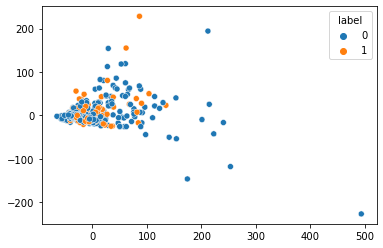

In [39]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import seaborn 

scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

pca = decomposition.PCA(n_components=3)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

seaborn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train)

<AxesSubplot:>

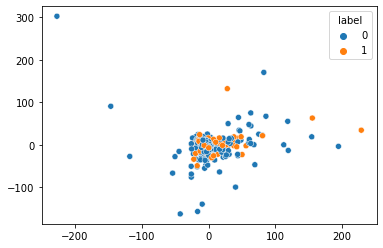

In [40]:
seaborn.scatterplot(x=X_pca[:, 1], y=X_pca[:, 2], hue=y_train)

Inseperable after PCA => need to look into more complex relations between features, linear combinations of features is not enough here; need something more complex. 

### Complexity evaluation

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def plot_learning_curve(clf, X_train, y_train):
    train_size, train_scores, test_scores = learning_curve(clf, X, y, verbose=2)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(12, 8))
    plt.title(f'Learning curve for {str(type(clf[-1])).split(".")[-1][:-2]}')
    plt.plot(train_size, train_mean, color='b', label='training')
    plt.plot(train_size, test_mean, color='orange', label='validation')

    plt.fill_between(train_size, train_mean-train_std, train_mean+train_std, color='b', alpha=0.3)
    plt.fill_between(train_size, test_mean-test_std, test_mean+test_std, color='orange', alpha=0.3)
    
    plt.grid()
    plt.ylim([0, 1.1])
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[learning_curve] Training set sizes: [ 66 214 363 512 661]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    7.3s finished


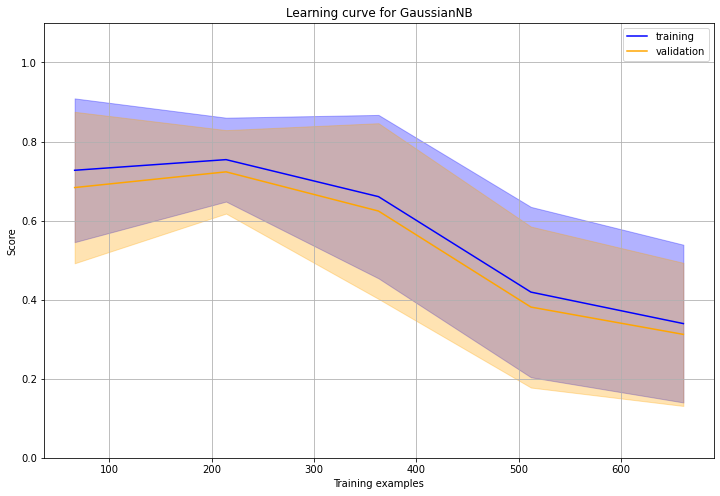

In [77]:
rs = ShuffleSplit(n_splits=1, test_size=.3, random_state=0)

for train_index, test_index in rs.split(X):
    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    random_forest = RandomForestClassifier()
    pca = PCA()

    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ("random_forest", random_forest)])

    parameters = {'random_forest__n_estimators': [50, 100, 500], 'random_forest__max_features': ['sqrt', 'log2', 0.2]}
    search = GridSearchCV(pipe, parameters, cv=2, scoring = 'f1', verbose=2)
    search.fit(X_train, y_train)

    best_clf = search.best_estimator_
    plot_learning_curve(best_clf, X, y) # denk dat we dit uit de for-loop moeten halen toch? 

In [70]:
best_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('random_forest',
                 RandomForestClassifier(max_features=0.2, n_estimators=500))])

In [4]:
from sklearn.metrics import f1_score, confusion_matrix
y_pred = best_clf.predict(X_test)
print(f1_score(y_test, y_pred))

pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['normal', 'abnormal'], index= ['normal', 'abnormal'])

NameError: name 'best_clf' is not defined

### Training and Evaluation loop

In [61]:
rs = ShuffleSplit(n_splits=5, test_size=.3, random_state=0)

scores = {'f1': [], 'accuracy': []}

for train_index, test_index in rs.split(X):
    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    random_forest = SVC()
    pca = PCA()

    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('select', SelectKBest()), ("random_forest", random_forest)])

    # Grid search
    parameters = {'select__k': [10, 20]}
    search = GridSearchCV(pipe, parameters, cv=2, scoring = 'f1', verbose=2)
    search.fit(X_train, y_train)

    # Evaluation

    #evaluation_grid= pd.DataFrame(search.cv_results_).sort_values('rank_test_score')
    #evaluation_grid.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'], axis=1).head(5)

    best_clf = search.best_estimator_
    y_pred = best_clf.predict(X_test)
    scores['f1'] += [f1_score(y_test, y_pred)]
    scores['accuracy'] += [accuracy_score(y_test, y_pred)] # accuracy kunnen we weghalen toch? Zegt heel weinig met onze dataset 


Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END .......................................select__k=10; total time=   0.8s
[CV] END .......................................select__k=10; total time=   0.8s
[CV] END .......................................select__k=20; total time=   0.4s
[CV] END .......................................select__k=20; total time=   0.5s
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END .......................................select__k=10; total time=   0.5s
[CV] END .......................................select__k=10; total time=   0.5s
[CV] END .......................................select__k=20; total time=   0.5s
[CV] END .......................................select__k=20; total time=   0.4s
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END .......................................select__k=10; total time=   0.4s
[CV] END .......................................select__k=10; total time=   0.4s
[CV] END ....

In [62]:
print(f'F1 score: {np.mean(scores["f1"])} +/- {np.std(scores["f1"])}')
print(f'Accuracy score: {np.mean(scores["accuracy"])} +/- {np.std(scores["accuracy"])}')

F1 score: 0.32153491436100134 +/- 0.03881012574830782
Accuracy score: 0.8353413654618475 +/- 0.012181326014540663


### Complexity - Learning Curve

In [7]:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

clf = search.best_estimator_

### Evaluation of classifier 

In [138]:
from sklearn.metrics import f1_score, confusion_matrix
best_clf = search.best_estimator_
y_pred = best_clf.predict(X_test)
f1_score(y_test, y_pred)


0.25396825396825395

In [139]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['normal', 'abnormal'], index= ['normal', 'abnormal'])

,normal,abnormal
normal,218,9
abnormal,38,8
